/home/akshara/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_125699/2920251265.py", line 46:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


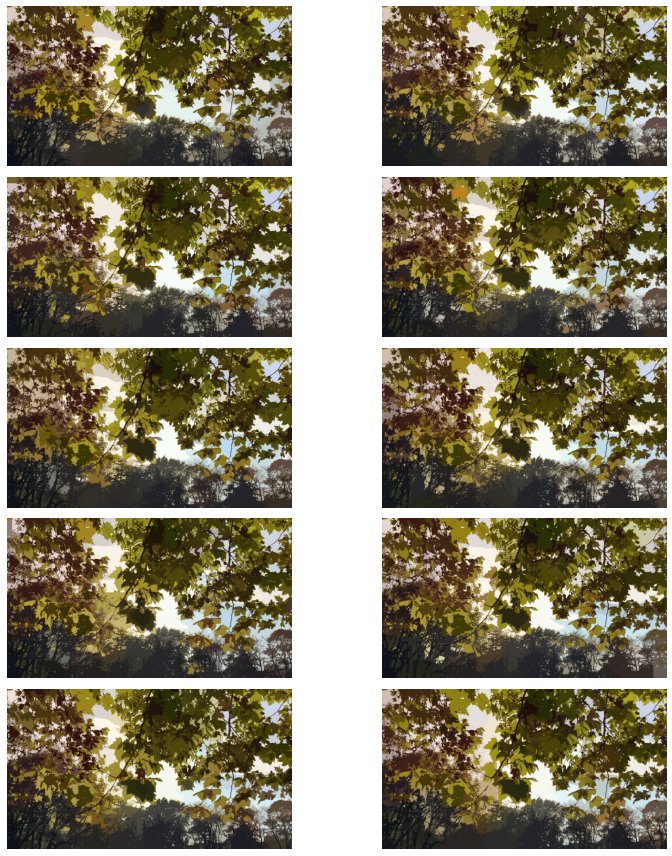

In [ ]:
import cv2
import numpy as np
from collections import defaultdict
from numba import jit
import matplotlib.pyplot as plt

# Superpixel generation by SLIC method from scratch

# Initialize random cluster centers
def initialize_cluster_centers_random(image, k):
    '''
    returns k random cluster centers and their coordinates
    '''
    cluster_centers = []
    cent_coordinates = []
    num_rows, num_cols = image.shape[0], image.shape[1]

    # Randomly select k pixels as cluster centers
    for _ in range(k):
        i = np.random.randint(0, num_rows)
        j = np.random.randint(0, num_cols)
        cluster_centers.append(image[i, j])
        cent_coordinates.append((i, j))
    
    return cluster_centers, cent_coordinates


@jit(nopython=True)
def dist_labsp(i, k):  # i and k are pixels
    '''
    returns the LAB space distance between two pixels
    '''
    i = np.clip(i, 0, 255).astype(np.float64)  # Clamp between 0 and 255
    k = np.clip(k, 0, 255).astype(np.float64)
    return np.sqrt((i[0] - k[0])**2 + (i[1] - k[1])**2 + (i[2] - k[2])**2)


@jit(nopython=True)
def dist_euc(i, k, m, s):  # i and k are pixel coordinates, m is compactness factor, s is cluster interval
    '''
    returns the Euclidean distance between two pixel coordinates
    '''
    return (m / s) * np.sqrt((i[0] - k[0])**2 + (i[1] - k[1])**2)


@jit(nopython=True, parallel=True)
def assign_pixels_to_single_cluster(image, mindistances, cluster_pixels, cluster_id, cent_coordinate, m, cluster_interval):
    '''
    assigns pixels to a single cluster within a restricted window
    '''
    for i in range(max(0, cent_coordinate[0] - 2 * cluster_interval), min(image.shape[0], cent_coordinate[0] + 2 * cluster_interval)):
        for j in range(max(0, cent_coordinate[1] - 2 * cluster_interval), min(image.shape[1], cent_coordinate[1] + 2 * cluster_interval)):
            d_lab = dist_labsp(image[i, j], image[cent_coordinate[0], cent_coordinate[1]])
            d_euc = dist_euc((i, j), cent_coordinate, m, cluster_interval)
            d = d_lab + d_euc
            if d < mindistances[i, j]:
                mindistances[i, j] = d
                cluster_pixels[i, j] = cluster_id  # Use the cluster ID directly


def assign_pixels_to_clusters(image, cent_coordinates, cluster_interval, m):
    '''
    assigns pixels to the nearest cluster and returns the clusters dictionary
    '''
    num_rows, num_cols = image.shape[:2]
    cluster_pixels = np.zeros((num_rows, num_cols))
    mindistances = np.full((num_rows, num_cols), np.inf)

    for idx, cent_coordinate in enumerate(cent_coordinates):
        # Call optimized function for each cluster, pass cluster ID separately
        assign_pixels_to_single_cluster(image, mindistances, cluster_pixels, idx, cent_coordinate, m, cluster_interval)

    clusters = defaultdict(list)
    for i in range(num_rows):
        for j in range(num_cols):
            clusters[cluster_pixels[i, j]].append([i, j])

    return clusters


def update_cluster_centers(clusters, image):
    '''
    updates the cluster centers by averaging the pixels in each cluster
    '''
    new_cluster_centers = []
    new_centre_coordinates = []
    for cluster, pixels in clusters.items():
        if len(pixels) > 0:
            # Get average LAB values and coordinates for the new center
            avg_lab = np.mean([image[p[0], p[1]] for p in pixels], axis=0)
            avg_coord = np.mean(pixels, axis=0).astype(int)
            new_cluster_centers.append(avg_lab)
            new_centre_coordinates.append(tuple(avg_coord))
    return new_cluster_centers, new_centre_coordinates


def create_superpixel_image(image, clusters):
    '''
    creates the result image with each pixel assigned to the average color of its cluster
    '''
    result_image = np.zeros_like(image)
    
    for cluster_idx, pixels in clusters.items():
        if len(pixels) == 0:
            continue  # Skip empty clusters

        # Compute the average color of all pixels in this cluster
        avg_color = np.mean([image[p[0], p[1]] for p in pixels], axis=0)
        
        # Assign the average color to all pixels in the cluster
        for p in pixels:
            result_image[p[0], p[1]] = avg_color

    return result_image



def display_images_in_notebook(image_list, cols=2, cmap='viridis'):
    '''
    Display all images in Jupyter Notebook in a grid.
    '''
    n = len(image_list)
    rows = (n + cols - 1) // cols  # Calculate number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
    axs = axs.flatten()  # Flatten in case there's a single row

    for i, img in enumerate(image_list):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')

    # Turn off any remaining axes if we have more plots than images
    for ax in axs[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Main Execution
image = cv2.imread('frame_0000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

k = 100  # number of clusters
num_pixels = image.shape[0] * image.shape[1]
cluster_interval = int(np.sqrt(num_pixels / k))

cluster_centers, cent_coordinates = initialize_cluster_centers_random(image, k)

m = 20  # compactness factor
iterations = 10

result_images = []  

for it in range(iterations):
    # Assign pixels to clusters
    clusters = assign_pixels_to_clusters(image, cent_coordinates, cluster_interval, m)
    # print('Iteration', it, 'Number of clusters:', len(clusters))
    
    cluster_centers, cent_coordinates = update_cluster_centers(clusters, image)
    
    result_image = create_superpixel_image(image, clusters)
    
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_LAB2RGB)
    
    result_images.append(result_image_rgb)

display_images_in_notebook(result_images)


Iteration 0 Number of clusters: 100
Iteration 1 Number of clusters: 100
Iteration 2 Number of clusters: 100
Iteration 3 Number of clusters: 100
Iteration 4 Number of clusters: 100
Iteration 5 Number of clusters: 100
Iteration 6 Number of clusters: 100
Iteration 7 Number of clusters: 100
Iteration 8 Number of clusters: 100
Iteration 9 Number of clusters: 100


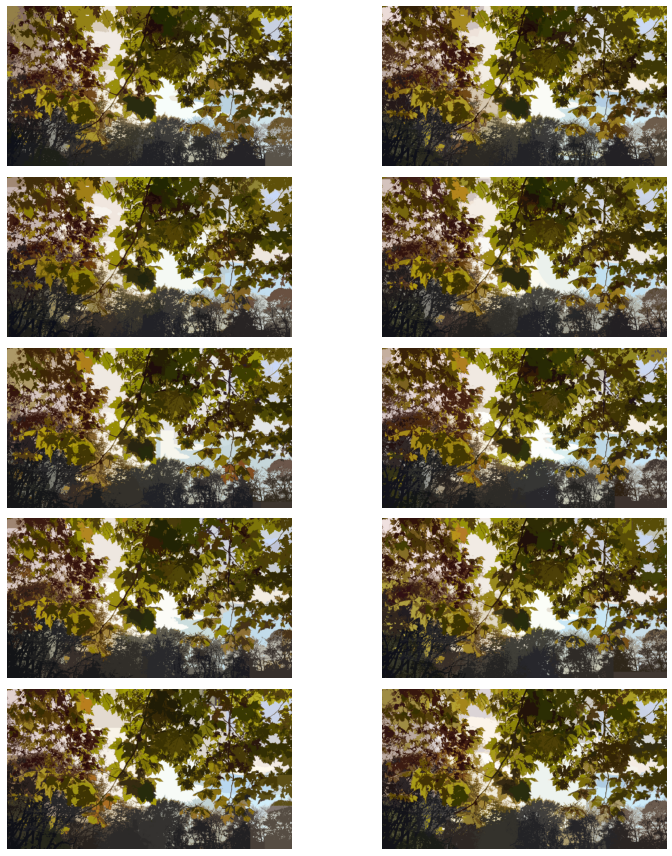

In [ ]:
# SLIC in RGB Space

@jit(nopython=True)
def dist_rgb(i, k):  # i and k are pixels in RGB space
    '''
    returns the RGB space distance between two pixels
    '''
    i = np.clip(i, 0, 255).astype(np.float64)  # Clamp between 0 and 255
    k = np.clip(k, 0, 255).astype(np.float64)
    return np.sqrt((i[0] - k[0])**2 + (i[1] - k[1])**2 + (i[2] - k[2])**2)

def assign_pixels_to_single_cluster_rgb(image, mindistances, cluster_pixels, cluster_id, cent_coordinate, m, cluster_interval):
    '''
    assigns pixels to a single cluster within a restricted window in RGB space
    '''
    for i in range(max(0, cent_coordinate[0] - 2 * cluster_interval), min(image.shape[0], cent_coordinate[0] + 2 * cluster_interval)):
        for j in range(max(0, cent_coordinate[1] - 2 * cluster_interval), min(image.shape[1], cent_coordinate[1] + 2 * cluster_interval)):
            d_rgb = dist_rgb(image[i, j], image[cent_coordinate[0], cent_coordinate[1]])
            d_euc = dist_euc((i, j), cent_coordinate, m, cluster_interval)
            d = d_rgb + d_euc
            if d < mindistances[i, j]:
                mindistances[i, j] = d
                cluster_pixels[i, j] = cluster_id  # Use the cluster ID directly


# Main Execution for RGB Space
image_rgb = cv2.imread('frame_0000.jpg')  # No need to convert to LAB, directly use the RGB image
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

k = 100  # number of clusters
num_pixels = image_rgb.shape[0] * image_rgb.shape[1]
cluster_interval = int(np.sqrt(num_pixels / k))

# Initialize cluster centers randomly
cluster_centers_rgb, cent_coordinates_rgb = initialize_cluster_centers_random(image_rgb, k)

m = 20  # compactness factor
iterations = 10

result_images_rgb = []  # To store images of each iteration

for it in range(iterations):
    clusters_rgb = assign_pixels_to_clusters(image_rgb, cent_coordinates_rgb, cluster_interval, m)
    print('Iteration', it, 'Number of clusters:', len(clusters_rgb))
    
    cluster_centers_rgb, cent_coordinates_rgb = update_cluster_centers(clusters_rgb, image_rgb)
    
    result_image_rgb = create_superpixel_image(image_rgb, clusters_rgb)
    
    result_images_rgb.append(result_image_rgb)

display_images_in_notebook(result_images_rgb)


In [ ]:
import os

super_pixeled_frames = []
directory = os.fsencode('frames')
for frame in os.listdir(directory):
    # do slic for each frame and save the result
    frame_path = os.path.join(directory, frame)
    frame_path = os.fsdecode(frame_path)
    frame = cv2.imread(frame_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    
    k = 100  # number of clusters
    num_pixels = frame.shape[0] * frame.shape[1]
    cluster_interval = int(np.sqrt(num_pixels / k))

    cluster_centers, cent_coordinates = initialize_cluster_centers_random(frame, k)
    m = 20  # compactness factor
    iterations = 10

    result_images = []  

    for it in range(iterations):
        # Assign pixels to clusters
        clusters = assign_pixels_to_clusters(image, cent_coordinates, cluster_interval, m)
        # print('Iteration', it, 'Number of clusters:', len(clusters))
        
        # Update cluster centers
        cluster_centers, cent_coordinates = update_cluster_centers(clusters, image)
        
        # if last iteration, save the result
        if it == iterations-1:
            result_image = create_superpixel_image(image, clusters)
            result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_LAB2RGB)
            result_images.append(result_image_rgb)
    
    super_pixeled_frames.append(result_images[-1])


        

In [ ]:
import cv2

output_video_path = 'superpixel_video.mp4'  # Output video file path
frame_height, frame_width = super_pixeled_frames[0].shape[:2]
fps = 10 

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

for frame in super_pixeled_frames:
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame_bgr)

video_writer.release()
print(f'Video saved to {output_video_path}')


Video saved to superpixel_video.mp4


In [18]:
import os
# optimized video segmentation

cluster_cent_coordinates_prev_frame = []

super_pixeled_frames = []
directory = os.fsencode('frames')
for id,frame in enumerate(os.listdir(directory)):
    # do slic for each frame and save the result
    frame_path = os.path.join(directory, frame)
    frame_path = os.fsdecode(frame_path)
    frame = cv2.imread(frame_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    
    k = 100  # number of clusters
    num_pixels = frame.shape[0] * frame.shape[1]
    cluster_interval = int(np.sqrt(num_pixels / k))

    cluster_centers, cent_coordinates = initialize_cluster_centers_random(frame, k)
    if id > 0:
        cent_coordinates = cluster_cent_coordinates_prev_frame
    m = 20  # compactness factor
    iterations = 10
    if id > 0:
        iterations = 2

    result_images = []  

    for it in range(iterations):
        # Assign pixels to clusters
        clusters = assign_pixels_to_clusters(image, cent_coordinates, cluster_interval, m)
        # print('Iteration', it, 'Number of clusters:', len(clusters))
        
        # Update cluster centers
        cluster_centers, cent_coordinates = update_cluster_centers(clusters, image)

        if it == iterations-1:
            cluster_cent_coordinates_prev_frame = cent_coordinates
        
        # if last iteration, save the result
        if it == iterations-1:
            result_image = create_superpixel_image(image, clusters)
            result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_LAB2RGB)
            result_images.append(result_image_rgb)
    
    super_pixeled_frames.append(result_images[-1])


        

In [19]:
import cv2

output_video_path = 'optimized_superpixel_video.mp4'  # Output video file path
frame_height, frame_width = super_pixeled_frames[0].shape[:2]
fps = 10 

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

for frame in super_pixeled_frames:
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame_bgr)

video_writer.release()
print(f'Video saved to {output_video_path}')

Video saved to optimized_superpixel_video.mp4
